In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("preprocess.csv",index_col=0, parse_dates=True)

In [3]:
df.isnull().sum()

rate              2
volume            2
cap               2
liquidity         2
rate_scaled       2
fg_value          0
Bitcoin           0
Cardano           0
cardano price     0
cryptocurrency    0
Ethereum          0
dtype: int64

In [4]:
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

df = df.drop_duplicates()

X = df.drop(columns = ["rate"])#, "rate_scaled"])
y = df[["rate"]]

X_timeseries = TimeSeries.from_dataframe(X, fill_missing_dates=True, freq="h")
y_timeseries = TimeSeries.from_dataframe(y, fill_missing_dates=True, freq="h")


X_timeseries = fill_missing_values(X_timeseries)
y_timeseries = fill_missing_values(y_timeseries)

<Axes: xlabel='time'>

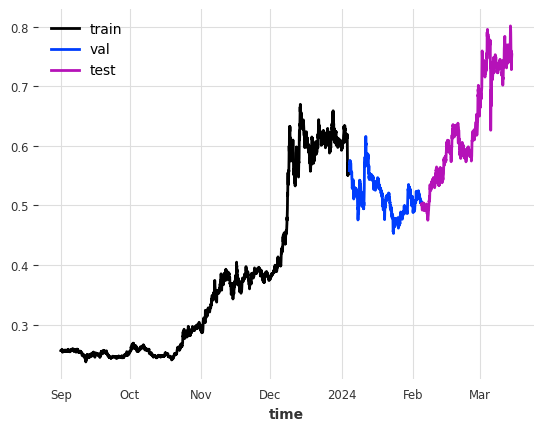

In [5]:
X_train, X_test = X_timeseries.split_before(0.8)
y_train, y_test = y_timeseries.split_before(0.8)

X_train, X_val = X_train.split_before(0.8)
y_train, y_val = y_train.split_before(0.8)

y_train.plot(label = "train")
y_val.plot(label = "val")
y_test.plot(label = "test")

In [6]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=7,
    min_delta=0.005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "cpu"}

In [7]:
from darts.models import BlockRNNModel
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
import torch

model = BlockRNNModel(

    model = "LSTM",

    input_chunk_length=120,

    output_chunk_length=24,

    dropout=0.2,

    loss_fn=torch.nn.MSELoss(),

    optimizer_cls = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.01}, #learning rate


    lr_scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau, #reduce learning rate when a metric has stopped improving
    #lr_scheduler_kwargs={"step_size": 10, "gamma": 0.1},

    torch_metrics=SymmetricMeanAbsolutePercentageError(),

    batch_size = 32,

    pl_trainer_kwargs = pl_trainer_kwargs,

    n_epochs=50

)

model.fit(series=y_train,    # the target training data
    past_covariates=X_train,     # the multi covariate features training data
    val_series=y_val,  # the target validation data
    val_past_covariates=X_val,   # the multi covariate features validation data
    verbose=False)


/home/marcel/.pyenv/versions/3.10.6/envs/cardano_crystal_ball/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/home/marcel/.pyenv/versions/3.10.6/envs/cardano_crystal_ball/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/marcel/.pyenv/versions/3.10.6/envs/cardano_crystal_ball/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |          | 0/? [00:00<?, ?it/s]

/home/marcel/.pyenv/versions/3.10.6/envs/cardano_crystal_ball/lib/python3.10/site-packages/pytorch_lightning/core/module.py:507: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.2, input_chunk_length=120, output_chunk_length=24, loss_fn=MSELoss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, torch_metrics=SymmetricMeanAbsolutePercentageError(), batch_size=32, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f7a4c197d00>], 'accelerator': 'cpu'}, n_epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

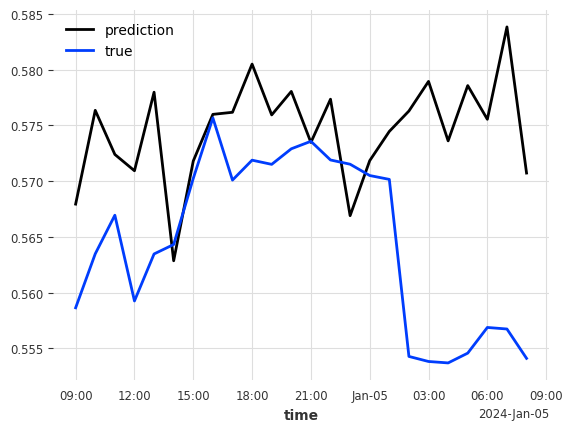

In [8]:
pred = model.predict(24)
pred.plot(label="prediction")
y_val[:24].plot(label="true")
#y_timeseries.plot(label="true")

In [13]:
from darts.metrics import smape

smape_score = smape(y_val, pred)

print(f"SMAPE: {smape_score:.2f} %")


SMAPE: 1.84 %


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<Axes: xlabel='time'>

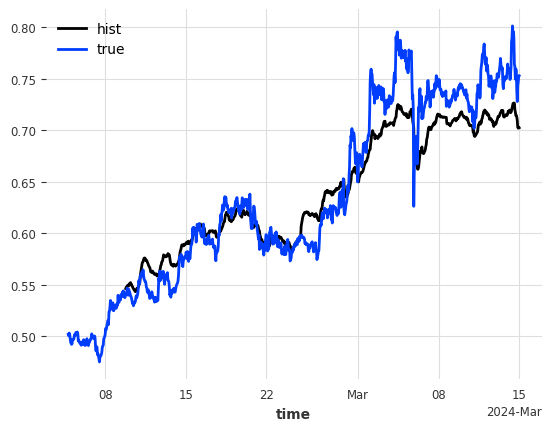

In [14]:
#backtest = model.backtest(retrain=False)
hist_fc = model.historical_forecasts(y_test, past_covariates=X_test, retrain=False)
hist_fc.plot(label="hist")
y_test.plot(label="true")

In [15]:
from darts.metrics import smape
smape_score_hist = smape(y_test, hist_fc)

print(f"SMAPE: {smape_score_hist:.2f} %")

#if we want to compare model, we have to use the exact same timespan and the same train, test, split size


SMAPE: 3.28 %


In [19]:
model.save("test.pt")

#model.reset_model()

In [20]:
model = model.load("test.pt")

/home/marcel/.pyenv/versions/3.10.6/envs/cardano_crystal_ball/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
